In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

# No need for 'from torch import torch.nn.BCELoss'
# Correct import statement for BCELoss
from torch.nn import BCELoss


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
%matplotlib inline

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Mounted at /content/drive


In [3]:
id='1HGabNmwqwRKYlCqLLsauyGPn8g72ogV2'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('crimes.csv')

In [4]:
crimes = pd.read_csv('crimes.csv')

# Assuming your original DataFrame is named 'df'
crimes_smaller = crimes.iloc[::100, :].copy()

print(crimes.dtypes)

crimes_smaller = crimes_smaller.drop(['Location', 'Latitude', 'Longitude', 'IUCR', 'FBI Code', 'Beat'], axis=1)
crimes = crimes.drop(['Location', 'Latitude', 'Longitude', 'IUCR', 'FBI Code', 'Beat'], axis=1)

crimes_smaller = crimes_smaller[~crimes_smaller['Year'].isin([2001, 2002])]
crimes = crimes[~crimes['Year'].isin([2001, 2002])]


ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object


In [5]:
crimes = crimes.dropna()
crimes_smaller = crimes_smaller.dropna()

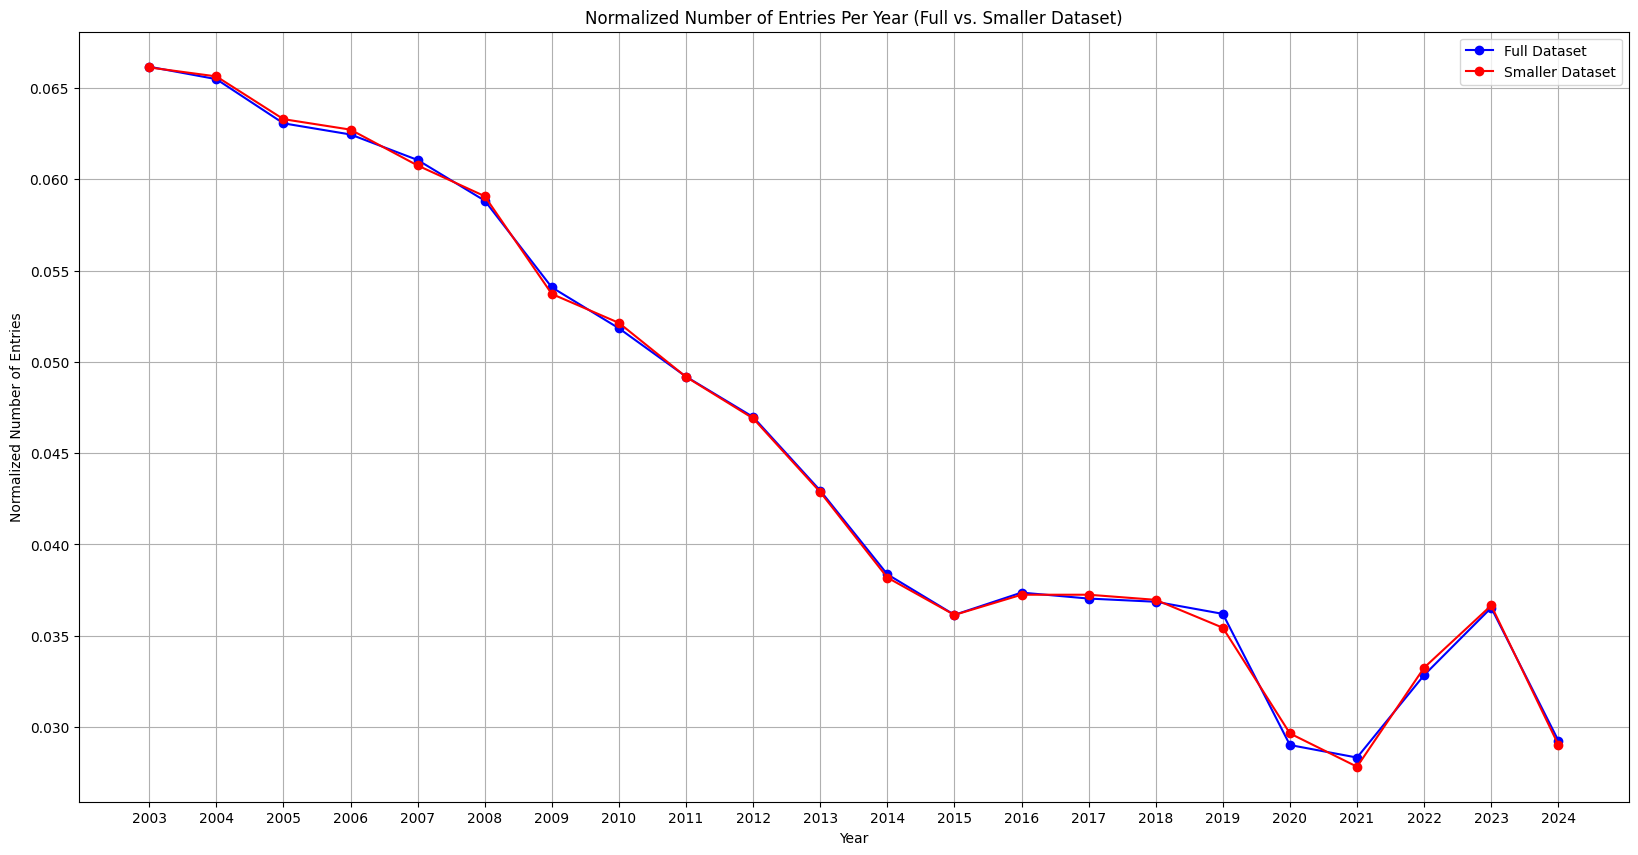

In [6]:
grouped_data_smaller_year = crimes_smaller.groupby('Year')
grouped_data_year = crimes.groupby('Year')

# Calculate the number of entries for each year
year_counts_smaller = grouped_data_smaller_year.size()
year_counts = grouped_data_year.size()

# Normalizing directly on the Pandas Series (preserving the index)
year_counts_normalized = year_counts / year_counts.sum()
year_counts_smaller_normalized = year_counts_smaller / year_counts_smaller.sum()

years_array = np.array(year_counts.index)

plt.figure(figsize=(20, 10))

# Plot the full dataset normalized counts
plt.plot(year_counts_normalized.index, year_counts_normalized.values, marker='o', linestyle='-', color='b', label='Full Dataset')

# Plot the smaller dataset normalized counts
plt.plot(year_counts_smaller_normalized.index, year_counts_smaller_normalized.values, marker='o', linestyle='-', color='r', label='Smaller Dataset')

# Labeling the plot
plt.xticks(years_array)
plt.xlabel('Year')
plt.ylabel('Normalized Number of Entries')
plt.title('Normalized Number of Entries Per Year (Full vs. Smaller Dataset)')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

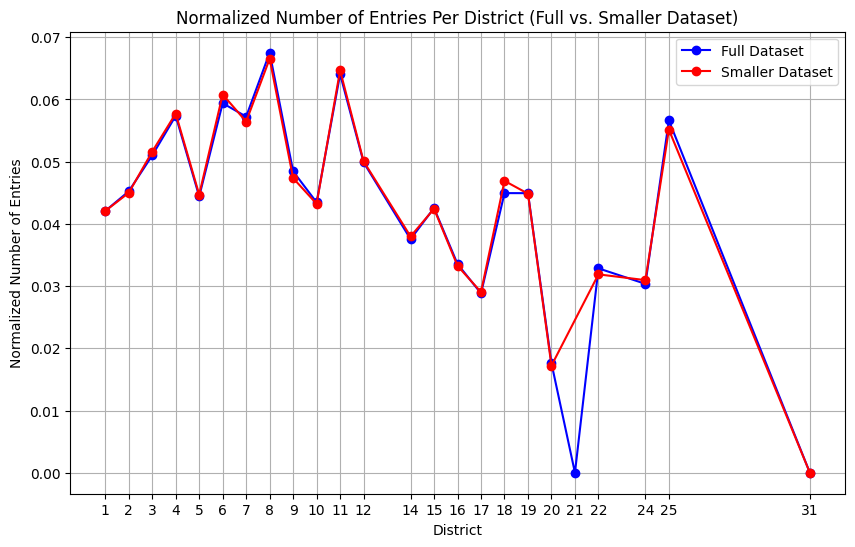

In [7]:
grouped_data_smaller_district = crimes_smaller.groupby('District')
grouped_data_district = crimes.groupby('District')

# Calculate the number of entries for each district
district_counts_smaller = grouped_data_smaller_district.size()
district_counts = grouped_data_district.size()

district_counts_normalized = district_counts / district_counts.sum()
district_counts_smaller_normalized = district_counts_smaller / district_counts_smaller.sum()

district_array = np.array(district_counts.index)
plt.figure(figsize=(10, 6))

plt.plot(district_counts_normalized.index, district_counts_normalized.values, marker='o', linestyle='-', color='b', label='Full Dataset')
plt.plot(district_counts_smaller_normalized.index, district_counts_smaller_normalized.values, marker='o', linestyle='-', color='r', label='Smaller Dataset')

plt.xticks(district_array)
plt.xlabel('District')
plt.ylabel('Normalized Number of Entries')
plt.title('Normalized Number of Entries Per District (Full vs. Smaller Dataset)')
plt.legend()
plt.grid(True)

plt.show()

In [8]:
print(crimes_smaller.dtypes)

ID                        int64
Case Number              object
Date                     object
Block                    object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
District                float64
Ward                    float64
Community Area          float64
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
dtype: object


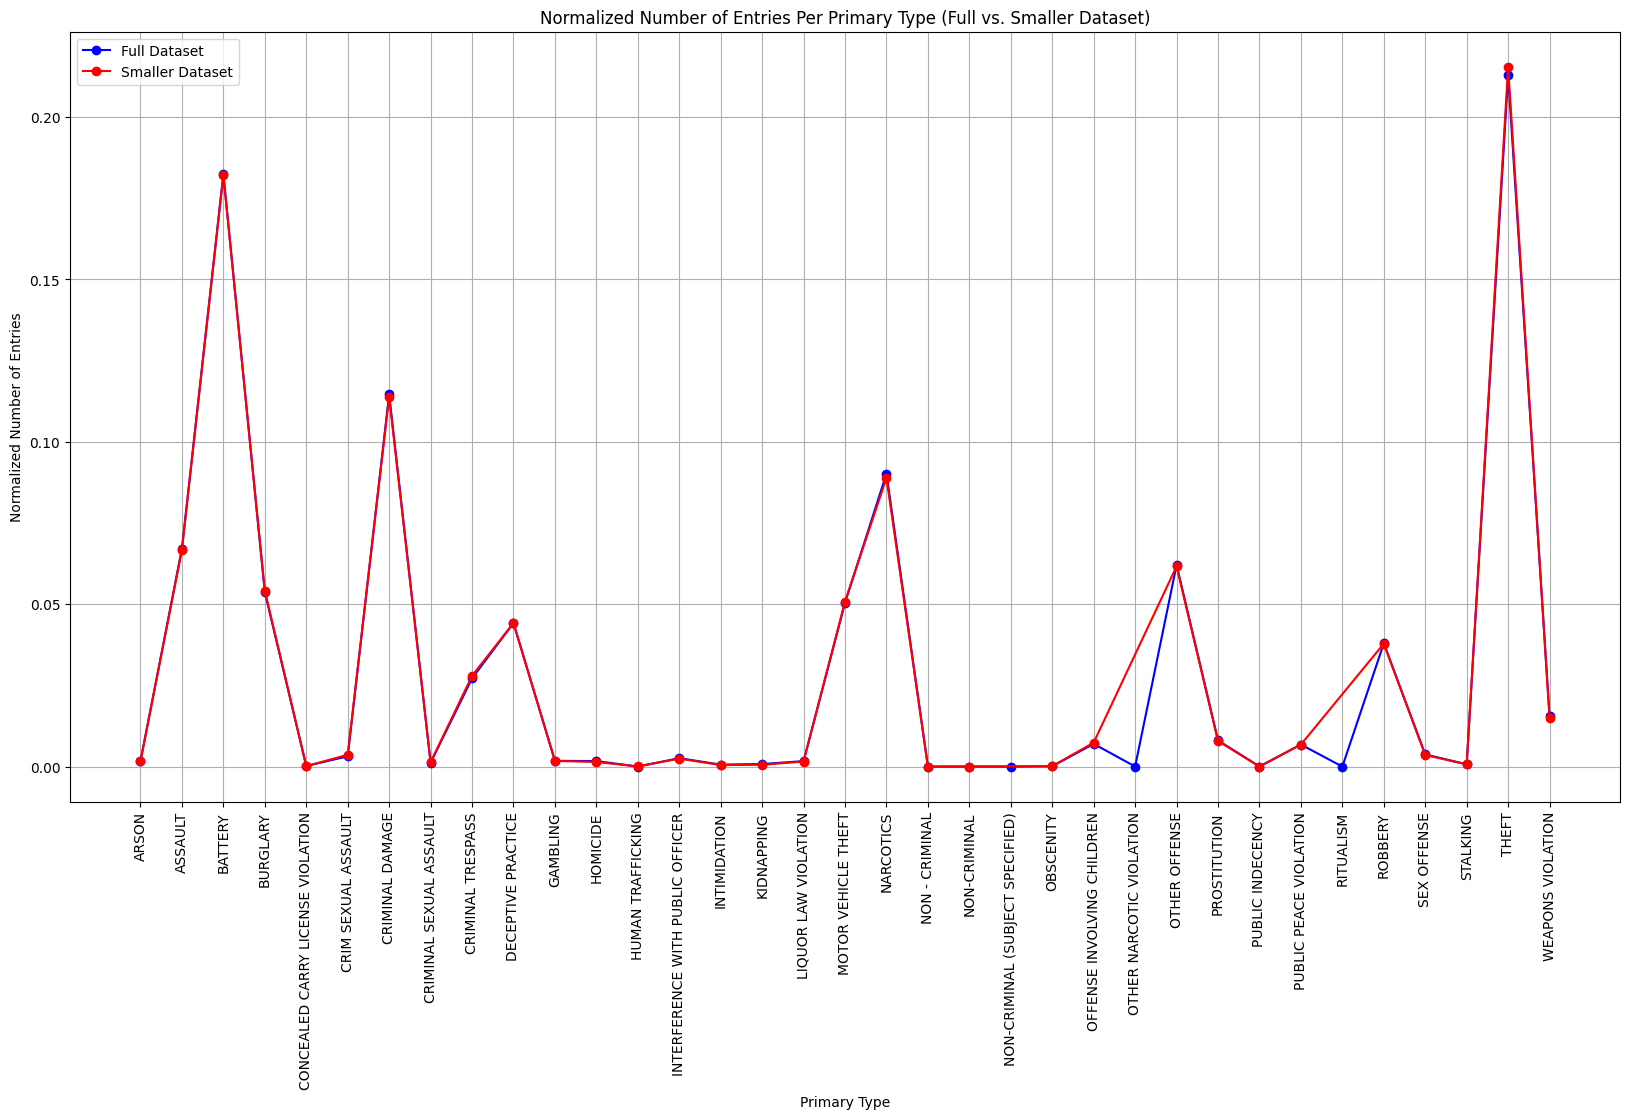

In [9]:
grouped_data_smaller_primary_type = crimes_smaller.groupby('Primary Type')
grouped_data_primary_type = crimes.groupby('Primary Type')

primary_type_counts_smaller = grouped_data_smaller_primary_type.size()
primary_type_counts = grouped_data_primary_type.size()

primary_type_counts_normalized = primary_type_counts / primary_type_counts.sum()
primary_type_counts_smaller_normalized = primary_type_counts_smaller / primary_type_counts_smaller.sum()

primary_type_array = np.array(primary_type_counts.index)

plt.figure(figsize=(20, 10))

plt.plot(primary_type_counts_normalized.index, primary_type_counts_normalized.values, marker='o', linestyle='-', color='b', label='Full Dataset')
plt.plot(primary_type_counts_smaller_normalized.index, primary_type_counts_smaller_normalized.values, marker='o', linestyle='-', color='r', label='Smaller Dataset')

plt.xticks(primary_type_array, rotation=90)
plt.xlabel('Primary Type')
plt.ylabel('Normalized Number of Entries')
plt.title('Normalized Number of Entries Per Primary Type (Full vs. Smaller Dataset)')
plt.legend()
plt.grid(True)

plt.show()

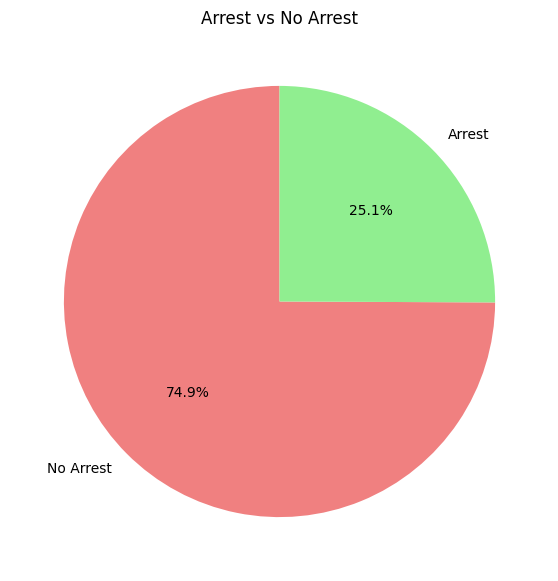

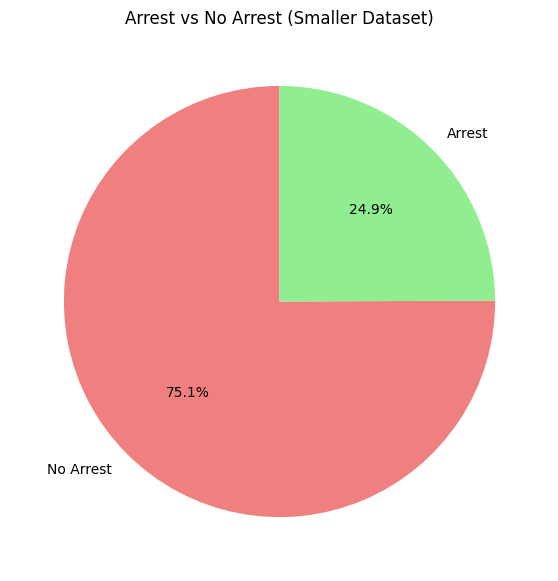

In [10]:
arrest_counts = crimes['Arrest'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(7, 7))
plt.pie(arrest_counts, labels=['No Arrest', 'Arrest'], autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'], startangle=90)

# Title for the pie chart
plt.title('Arrest vs No Arrest')

arrest_counts_smaller = crimes_smaller['Arrest'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(arrest_counts_smaller, labels=['No Arrest', 'Arrest'], autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'], startangle=90)

plt.title('Arrest vs No Arrest (Smaller Dataset)')

plt.show()

In [11]:
X_list = crimes['X Coordinate'].tolist()
Y_list = crimes['Y Coordinate'].tolist()

X_list_smaller = crimes_smaller['X Coordinate'].tolist()
Y_list_smaller = crimes_smaller['Y Coordinate'].tolist()

In [12]:
x_max = max(X_list)
x_min = min(Y_list)
y_max = max(X_list_smaller)
y_min = min(Y_list_smaller)

# Print the results
print("Max of x:", x_max)
print("Min of x:", x_min)
print("Max of y:", y_max)
print("Min of y:", y_min)


Max of x: 1205119.0
Min of x: 0.0
Max of y: 1205117.0
Min of y: 0.0


In [13]:
crimes_smaller = crimes_smaller.drop(['ID', 'Case Number'], axis=1)

In [14]:
unique_descriptions_count = crimes_smaller['Description'].nunique()
print("Number of distinct values in 'Description':", unique_descriptions_count)
unique_primary_types_count = crimes_smaller['Primary Type'].nunique()
print("Number of distinct values in 'Primary Type':", unique_primary_types_count)

Number of distinct values in 'Description': 395
Number of distinct values in 'Primary Type': 32


In [15]:
unique_types = crimes_smaller['Primary Type'].unique()
type_to_index = {type_name: i for i, type_name in enumerate(unique_types)}

# Convert each category to a one-hot encoded vector in a single column
crimes_smaller['Primary Type Encoded'] = crimes_smaller['Primary Type'].map(
    lambda x: np.eye(len(unique_types))[type_to_index[x]]
)

# Display the DataFrame
print(crimes_smaller[['Primary Type', 'Primary Type Encoded']])

                Primary Type  \
100                  BATTERY   
200                    THEFT   
300      MOTOR VEHICLE THEFT   
400            OTHER OFFENSE   
700                    THEFT   
...                      ...   
8187200   DECEPTIVE PRACTICE   
8187400   DECEPTIVE PRACTICE   
8187500                THEFT   
8187600    WEAPONS VIOLATION   
8187700              BATTERY   

                                      Primary Type Encoded  
100      [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
200      [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
300      [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
400      [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
700      [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
...                                                    ...  
8187200  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
8187400  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
8187500  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
81876

In [16]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [17]:
X = crimes_smaller.drop(['Primary Type', 'Description', 'Location Description', 'Ward', 'Block', 'Community Area', 'Arrest'], axis=1)
Y = crimes_smaller['Arrest'].astype(int)

In [18]:
X['Date'] = pd.to_datetime(X['Date'])

# Extract useful features from the 'Date' column
X['Year'] = X['Date'].dt.year
X['Month'] = X['Date'].dt.month
X['Day'] = X['Date'].dt.day
X['DayOfWeek'] = X['Date'].dt.weekday   # Monday=0, Sunday=6
X['Hour'] = X['Date'].dt.hour
X['AM_PM'] = X['Date'].dt.hour.apply(lambda x: 0 if x < 12 else 1)
X['DayOfYear'] = X['Date'].dt.dayofyear

# Drop the original 'Date' column as it's no longer needed
X = X.drop(columns=['Date'])


In [19]:
X = X.drop(['Updated On'], axis=1)

In [20]:
print(X.dtypes)

Domestic                   bool
District                float64
X Coordinate            float64
Y Coordinate            float64
Year                      int32
Primary Type Encoded     object
Month                     int32
Day                       int32
DayOfWeek                 int32
Hour                      int32
AM_PM                     int64
DayOfYear                 int32
dtype: object


In [21]:
X = X.drop(['DayOfYear'], axis=1)
X_copy = X


In [22]:
print(X_copy.dtypes)

Domestic                   bool
District                float64
X Coordinate            float64
Y Coordinate            float64
Year                      int32
Primary Type Encoded     object
Month                     int32
Day                       int32
DayOfWeek                 int32
Hour                      int32
AM_PM                     int64
dtype: object


In [23]:
print(X.head())

     Domestic  District  X Coordinate  Y Coordinate  Year  \
100      True      14.0     1153807.0     1908780.0  2020   
200     False      12.0     1163312.0     1897077.0  2020   
300     False      24.0     1164374.0     1946140.0  2020   
400     False       4.0     1199187.0     1847619.0  2020   
700      True      25.0     1142089.0     1913063.0  2023   

                                  Primary Type Encoded  Month  Day  DayOfWeek  \
100  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      5    2          5   
200  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      8   19          2   
300  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      7   13          0   
400  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      9    4          4   
700  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      8   20          6   

     Hour  AM_PM  
100     2      0  
200    21      1  
300    15      1  
400     0      0  
700     6      0  


In [24]:
primary_type_encoded_array = np.array(X['Primary Type Encoded'].tolist())

# Optionally, drop the original column from the DataFrame if you want only numerical data for PyTorch
X = X.drop(columns=['Primary Type Encoded'])


# Concatenate the array back to X if needed, ensuring compatibility with PyTorch inputs
X = np.concatenate([X.values, primary_type_encoded_array], axis=1)

In [25]:

def convert_array(a):
    # If a is a numpy array, directly cast it to float32
    if isinstance(a, np.ndarray):
        a = a.astype(np.int32)
    return a

# Example usage
X = np.array(X)  # Ensure X is a numpy array
X = convert_array(X)

Y = Y.to_numpy()

In [26]:
X_tensor = torch.tensor(X, dtype=torch.int32)
Y_tensor = torch.tensor(Y, dtype=torch.int32)

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

In [66]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [67]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        # Define layers
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
          nn.Linear(input_size, 128),  # First layer (input_size -> 128 neurons)
          nn.ReLU(),
          nn.Linear(128, 64),  # Second layer (128 -> 64 neurons)
          nn.ReLU(),
          nn.Linear(64, output_size),  # Output layer (64 -> output_size neurons)
          nn.Sigmoid()
        )

    def forward(self, x):
        # Forward pass
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x





# Initialize the model
input_size = X_train.shape[1]  # Number of features
output_size = 1  # Number of unique classes in Y (for classification)

model = NeuralNetwork(input_size, output_size).to(device)
print(model)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=42, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [68]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [69]:
X_tensor = torch.tensor(X, dtype=torch.float32)  # Convert to float32 for input
Y_tensor = torch.tensor(Y, dtype=torch.long)     # Convert to long for labels

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

# Create TensorDataset objects for training and test data
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

# Create DataLoader objects for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Now you can use these DataLoaders in your training loop


In [70]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize loss for the epoch
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)  # Move data to the appropriate device

        # Forward pass: Compute predicted y by passing x to the model
        pred = model(X)

        # The output from the model will be probabilities (from sigmoid)
        loss = loss_fn(pred.squeeze(), y.float())  # .squeeze() to remove extra dimension if necessary

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Zero gradients after the update
        optimizer.zero_grad()

        # Accumulate the loss for the current batch
        epoch_loss += loss.item()

    # Return the average loss for the epoch
    return epoch_loss / size


In [73]:
# Assuming you have:
# - train_loader: DataLoader for your training data
# - model: Your neural network model
# - loss_fn: BCE loss (Binary Cross-Entropy Loss)
# - optimizer: Optimizer like Adam or SGD
# - device: "cuda" for GPU or "cpu" for CPU
num_epochs = 100

for epoch in range(num_epochs):

    # Train for one epoch and get the average loss
    epoch_loss = train(train_loader, model, loss_fn, optimizer, device)

    # Print the loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {epoch_loss:.4f}")


Epoch [10/100], Average Loss: 1.1738
Epoch [20/100], Average Loss: 1.1737
Epoch [30/100], Average Loss: 1.1737
Epoch [40/100], Average Loss: 1.1739
Epoch [50/100], Average Loss: 1.1738
Epoch [60/100], Average Loss: 1.1738
Epoch [70/100], Average Loss: 1.1740
Epoch [80/100], Average Loss: 1.1738
Epoch [90/100], Average Loss: 1.1737
Epoch [100/100], Average Loss: 1.1739
